In [ ]:
#DMEnv
import dataclasses
from typing import Any, Iterator, Tuple, Union

import flax.linen as nn
import gymnasium as gym
import jax
import jax.numpy as jnp
import mediapy
import numpy as np
import skrl
import skrl.envs.wrappers.jax as skrl_wrappers
from jax import jit
from jax import numpy as jnp
from skrl.agents.jax.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.models.jax import GaussianMixin, Model
from skrl.trainers.jax import SequentialTrainer
from skrl.utils.spaces.jax import flatten_tensorized_space, tensorize_space
from tqdm import tqdm
from waymax import agents
from waymax import config as _config
from waymax import dataloader, datatypes, dynamics
from waymax import env as _env
from waymax import visualization
from waymax.agents.actor_core import ActorState
from waymax.env.wrappers.dm_env_wrapper import make_sdc_dm_environment

# path = "gs://waymo_open_dataset_motion_v_1_3_0/uncompressed/tf_example/training/training_tfexample.tfrecord@1000"
path = "./data/training_tfexample.tfrecord@5"
max_num_objects = 32
data_loader_config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    path=path,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
)
data_iter = dataloader.simulator_state_generator(config=data_loader_config)
sim_agent_config = _config.SimAgentConfig(
    agent_type=_config.SimAgentType.IDM, controlled_objects=_config.ObjectType.NON_SDC
)
env_config = dataclasses.replace(
    _config.EnvironmentConfig(),
    max_num_objects=max_num_objects,
    sim_agents=[sim_agent_config],
)
dynamics_model = dynamics.InvertibleBicycleModel(normalize_actions=True)
env=make_sdc_dm_environment(dynamics_model,data_loader_config, env_config)
actor = agents.create_expert_actor(dynamics_model=dynamics_model)
jit_select_action = jax.jit(actor.select_action)
jit_select_by_onehot = jax.jit(datatypes.select_by_onehot)


# Reset environment with new state
timestep=env.reset()
rng = jax.random.key(0)
actor_state = actor.init(rng, env.simulation_state)


# Run the environment
@jit
def run(timestep: TimeStep, actor_state: ActorState, rng):
    states = [timestep.state]
    for _ in tqdm(range(80)):
        action = jit_select_action({}, env.simulation_state, actor_state, rng).action
        action = jit_select_by_onehot(action, timestep.state.object_metadata.is_sdc)
        timestep = env.step(action)
        states.append(env.simulation_state)
    return states
    
states=run(timestep, actor_state, rng)


# Visualize the scenario
imgs = []
for state in states:
    imgs.append(visualization.plot_simulator_state(state, use_log_traj=False))
mediapy.show_video(imgs, fps=10)



[skrl:WARNING] IsaacGymEnvs runs on GPU, but there is no GPU backend for JAX. JAX operations will run on CPU.
[skrl:WARNING] Isaac Lab runs on GPU, but there is no GPU backend for JAX. JAX operations will run on CPU.
[skrl:WARNING] OmniIsaacGymEnvs runs on GPU, but there is no GPU backend for JAX. JAX operations will run on CPU.


100%|██████████| 80/80 [00:02<00:00, 30.97it/s]


In [ ]:
import dataclasses
from typing import Any, Dict, Iterator, List, Sequence, Tuple, Union, override

import flax
import flax.linen as nn
import gymnasium
import skrl
import jax
import jax.numpy as jnp
import mediapy
import numpy as np
import skrl.envs.wrappers.jax as skrl_wrappers
from skrl import config
from dm_env import specs
from jax import jit
from skrl.agents.jax.ppo import PPO, PPO_DEFAULT_CONFIG
from skrl.memories.jax import RandomMemory
from skrl.models.jax import DeterministicMixin, GaussianMixin, Model
from skrl.trainers.jax import SequentialTrainer
from tqdm import tqdm
from waymax import agents
from waymax import config as _config
from waymax import dataloader, datatypes, dynamics
from waymax import env as _env
from waymax import visualization

# Set the backend to "jax" or "numpy"
config.jax.backend = "jax"

# path = "gs://waymo_open_dataset_motion_v_1_3_0/uncompressed/tf_example/training/training_tfexample.tfrecord@1000"
path = "./data/training_tfexample.tfrecord@5"
max_num_objects = 32
data_loader_config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    path=path,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
)
data_iter = dataloader.simulator_state_generator(config=data_loader_config)
sim_agent_config = _config.SimAgentConfig(
    agent_type=_config.SimAgentType.IDM, controlled_objects=_config.ObjectType.NON_SDC
)
env_config = dataclasses.replace(
    _config.EnvironmentConfig(),
    max_num_objects=max_num_objects,
    sim_agents=[sim_agent_config],
)
dynamics_model = dynamics.InvertibleBicycleModel(normalize_actions=True)
env = _env.PlanningAgentEnvironment(
    dynamics_model=dynamics_model,
    config=env_config,
    sim_agent_actors=[agents.create_sim_agents_from_config(sim_agent_config)],
    sim_agent_params=[{}],
)
actor = agents.create_expert_actor(dynamics_model=dynamics_model)


class WaymaxWrapper(skrl_wrappers.Wrapper):
    def __init__(
        self,
        env: _env.PlanningAgentEnvironment,
        scenario_loader: Iterator[datatypes.SimulatorState],
    ):
        super().__init__(env)
        self._jax = True
        self._env = env
        self._scenario_loader = scenario_loader
        self._jit_step = jit(self._env.step)
        self._jit_reset = jit(self._env.reset)
        self._jit_observe = jit(self._env.observe)
        self._jit_reward = jit(self._env.reward)
        self._jit_truncation = jit(self._env.truncation)
        self._jit_termination = jit(self._env.termination)

    @override
    def reset(self) -> Tuple[Union[np.ndarray, jax.Array], Any]:
        """Reset the environment

        :return: Observation, info
        :rtype: np.ndarray or jax.Array and any other info
        """
        self._state = self._env.reset(next(self._scenario_loader))
        observation = self._jit_observe(self._state)
        return observation, {}

    @override
    def step(self, actions: Union[np.ndarray, jax.Array]) -> Tuple[
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Union[np.ndarray, jax.Array],
        Any,
    ]:
        """Perform a step in the environment

        :param actions: The actions to perform
        :type actions: np.ndarray or jax.Array

        :return: Observation, reward, terminated, truncated, info
        :rtype: tuple of np.ndarray or jax.Array and any other info
        """
        action = datatypes.Action(
            data=jnp.array(actions), valid=jnp.array([True])  # type: ignore
        )
        self._state = self._jit_step(self._state, action)
        reward = self._jit_reward(self._state, action)
        observation = self._jit_observe(self._state)
        terminated = self._env.termination(self._state)
        truncated = self._env.truncation(self._state)
        return observation, reward, terminated, truncated, {}

    def state(self) -> Union[np.ndarray, jax.Array]:
        """Get the environment state

        :raises NotImplementedError: Not implemented

        :return: State
        :rtype: np.ndarray or jax.Array
        """
        raise NotImplementedError

    def render(self, *args, **kwargs) -> Any:
        """Render the environment

        :return: Any value from the wrapped environment
        :rtype: any
        """
        pass

    def close(self) -> None:
        """Close the environment"""
        pass

    @property
    def observation_space(self) -> gymnasium.Space:
        """The observation specs of this environment, without batch dimension."""
        observation_spec: specs.BoundedArray = self._env.observation_spec()
        return gymnasium.spaces.Box(
            low=observation_spec.minimum, high=observation_spec.maximum, dtype=observation_spec.dtype  # type: ignore
        )

    @property
    def action_space(self) -> gymnasium.Space:
        """Action space"""
        action_spec: specs.BoundedArray = self._env.action_spec().data  # type: ignore
        return gymnasium.spaces.Box(
            low=action_spec.minimum, high=action_spec.maximum, dtype=action_spec.dtype  # type: ignore
        )


env = WaymaxWrapper(env, data_iter)


class Policy(GaussianMixin, Model):
    def __init__(
        self,
        observation_space,
        action_space,
        device=None,
        clip_actions=False,
        clip_log_std=True,
        min_log_std=-20,
        max_log_std=2,
        reduction="sum",
        **kwargs
    ):
        Model.__init__(self, observation_space, action_space, device, **kwargs)
        GaussianMixin.__init__(
            self, clip_actions, clip_log_std, min_log_std, max_log_std, reduction
        )

    @nn.compact  # marks the given module method allowing inlined submodules
    def __call__(self, inputs, role):
        x = nn.relu(nn.Dense(64)(inputs["states"]))
        x = nn.relu(nn.Dense(64)(x))
        x = nn.Dense(self.num_actions)(x)
        log_std = self.param("log_std", lambda _: jnp.zeros(self.num_actions))
        # Pendulum-v1 action_space is -2 to 2
        return 2 * nn.tanh(x), log_std, {}


class Value(DeterministicMixin, Model):
    def __init__(
        self, observation_space, action_space, device=None, clip_actions=False, **kwargs
    ):
        Model.__init__(self, observation_space, action_space, device, **kwargs)
        DeterministicMixin.__init__(self, clip_actions)

    @nn.compact  # marks the given module method allowing inlined submodules
    def __call__(self, inputs, role):
        x = nn.relu(nn.Dense(64)(inputs["states"]))
        x = nn.relu(nn.Dense(64)(x))
        x = nn.Dense(1)(x)
        return x, {}


# instantiate a memory as rollout buffer (any memory can be used for this)
memory = RandomMemory(memory_size=1024, num_envs=env.num_envs)


# instantiate the agent's models (function approximators).
# PPO requires 2 models, visit its documentation for more details
# https://skrl.readthedocs.io/en/latest/api/agents/ppo.html#models
models = {}
models["policy"] = Policy(env.observation_space, env.action_space, clip_actions=True)
models["value"] = Value(env.observation_space, env.action_space)

# instantiate models' state dict
for role, model in models.items():
    model.init_state_dict(role)


# configure and instantiate the agent (visit its documentation to see all the options)
# https://skrl.readthedocs.io/en/latest/api/agents/ppo.html#configuration-and-hyperparameters
cfg = PPO_DEFAULT_CONFIG.copy()

agent = PPO(
    models=models,
    memory=memory,
    cfg=cfg,
    observation_space=env.observation_space,
    action_space=env.action_space,
)


# configure and instantiate the RL trainer
cfg_trainer = {"timesteps": 100000, "headless": True}
trainer = SequentialTrainer(cfg=cfg_trainer, env=env, agents=[agent])

# start training
trainer.train()


self._jax True
  0%|          | 79/100000 [00:01<39:37, 42.02it/s]  


IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed

KeyboardInterrupt: 

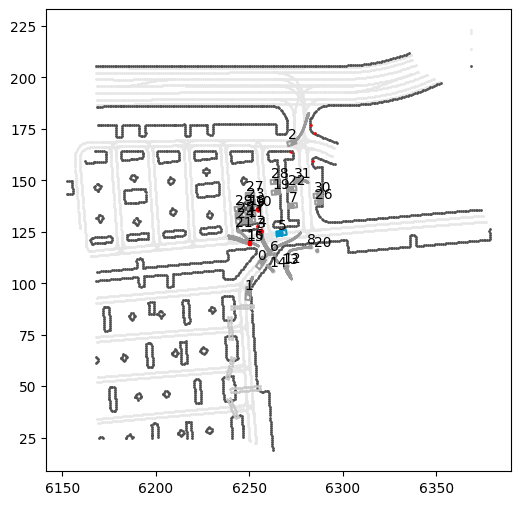

In [6]:
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as _config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization

max_num_objects = 32
config = dataclasses.replace(
    _config.WOD_1_1_0_TRAINING,
    max_num_objects=max_num_objects,
    max_num_rg_points=30000,
    path="./data/training_tfexample.tfrecord@5",
)
data_iter = dataloader.simulator_state_generator(config=config)
scenario = next(data_iter)


img = visualization.plot_simulator_state(scenario, use_log_traj=True)
imgs = [img]
state = scenario
for _ in range(scenario.remaining_timesteps):
  state = datatypes.update_state_by_log(state, num_steps=1)
  imgs.append(visualization.plot_simulator_state(state, use_log_traj=True))


mediapy.show_video(imgs, fps=10)